
# Introduction to Steady-state Visual Evoked Potentials (SSVEP) Brain-Computer Interfaces (BCI)



#### Brain Computer Interfaces (BCIs)
Brain-computer interfaces (BCIs) provide a direct pathway between the human brain and an external device, and can be especially useful for people with severe disabilities. A BCI can bypass the damaged pathways in order to provide the user with the ability to communicate or interact effectively with their surroundings. BCIs provide novel possibilities for neurorehabilitation for people with neurological disease such as stroke, amyotrophic lateral sclerosis (ALS) or paralysis.

There are two types of BCIs: endogenous and exogenous BCIs. Endogenous BCIs allows the user to voluntarily modulate
his/her neuronal activity based on intention. For example: Motor Imagery (MI BCI) – the user imagines a motor
movement such as moving the right hand/left hand or imagines lifting up the ankle (ankle
dorsiflexion). Exogenous BCIs are based on responses elicited due to an external stimulus. These responses are generated when the user focuses his/her attention on a stimulus which is associated with a BCI command. Examples include P300 BCI, steady-state visual evoked potentials (SSVEP) based BCIs, steady-state motion visual evoked potential (SSMVEP) BCIs, etc. 


#### Steady-state Visual evoked Potentials (SSVEP) based BCI

Steady-state visual evoked potentials are responses elicited when a user focuses his/her attention on a repetitive visual stimulus (a light source) flickering at frequencies higher than 6 Hz. These are periodic responses prominently observed in the occipital and occipito-parietal areas of the cortex. SSVEP responses appear as an increase in the amplitude of the signal at the fundamental frequency and its harmonics for the corresponding stimulus attended by the user. Therefore, by analyzing the dominant frequency response in the EEG, the stimulus attended to by the user can be identified. 

Video: https://youtu.be/cd4m2flXS2U

#### In this tutorial, we will be looking into a 12-class SSVEP dataset and plot these responses in the EEG.

<img src="12_classSSVEP.png">

In this example, there are 12 SSVEP stimuli flashing at the corresponsing flicker frequencies. The user gazes at one of the flickering targets in random order for 4 seconds. In this way 15 trials are recorded from 8 EEG channels. For more details please refer to the paper.



#### Dataset URL: 
https://github.com/mnakanishi/12JFPM_SSVEP/tree/master/data

#### Dataset Paper:
Masaki Nakanishi, Yijun Wang, Yu-Te Wang and Tzyy-Ping Jung, 
"A Comparison Study of Canonical Correlation Analysis Based Methods for Detecting Steady-State Visual Evoked Potentials," 
PLoS One, vol.10, no.10, e140703, 2015. 

#### Implementation:
Note: Following implementation plots the frequency response of each flicker frequency across all trials on channel Oz. To visualize each flicker frequency's response, in this code, we average across all trials. 

Aravind Ravi | eBionics Lab | University of Waterloo

In [96]:
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import math
import numpy as np

In [97]:
#Buffer implementation similar to MATLAB - Segmentation of signal/windowing
def buffer(data,duration,data_overlap):
    number_segments = int(math.ceil((len(data)-data_overlap)/(duration-data_overlap)))
    #print(data.shape)
    temp_buf = [data[i:i+duration] for i in range(0,len(data),(duration-int(data_overlap)))]
    temp_buf[number_segments-1] = np.pad(temp_buf[number_segments-1],(0,duration-temp_buf[number_segments-1].shape[0]),'constant')
    temp_buf2 = np.vstack(temp_buf[0:number_segments])
    return temp_buf2

In [98]:
#Digital Filter Bandpass zero-phase Implementation (filtfilt)
def butterBandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butterBandpassFilter(data, lowcut, highcut, fs, order):
    b, a = butterBandpass(lowcut, highcut, fs, order)
    y = filtfilt(b, a, data)
    return y

In [99]:
def loadDataPlFft(sub,plt_chan,resolution,start_freq,end_freq):
    #Load EEG Dataset
    dataset=sio.loadmat('s'+str(sub)+'.mat')

    eeg=np.array(dataset['eeg'],dtype='float32')

    #Reading the required parameters
    #Number of classes
    num_classes=eeg.shape[0]

    #Number of EEG channels
    num_chan=eeg.shape[1]

    #Trial length of EEG
    total_trial_len=eeg.shape[2]

    #Total number of trials
    num_trials=eeg.shape[3]
    sample_rate = 256

    #SSVEP flicker frequencies used for the 12 SSVEP targets   
    flicker_freq=np.array([9.25,11.25,13.25,9.75,11.75,13.75,10.25,12.25,14.25,10.75,12.75,14.75])

    labels=[]

    #Extract the actual trial from the data (refer the paper for more details)
    trial_len=int(38+0.135*sample_rate+4*sample_rate-1) - int(38+0.135*sample_rate)
    filtered_data = np.zeros((eeg.shape[0],eeg.shape[1],trial_len,eeg.shape[3]))

    #Iterate through the channels and trials for filtering the data using Bandpass filter between 6 Hz and 80 Hz
    for cl in range(0,num_classes):
        for ch in range(0,num_chan):
            for tr in range(0,num_trials):    
                filtered_data[cl,ch,:,tr] = butterBandpassFilter(np.squeeze(eeg[cl,ch,int(38+0.135*sample_rate):int(38+0.135*sample_rate+4*sample_rate-1),tr]),6,80,sample_rate,4)

    eeg=[]

    #Segment the EEG trials into 1 second non-overlapping segments 
    #Window/segment length in seconds
    window_len=4

    #Shift of the window in seconds (indirectly specifies overlap)
    shift_len=4

    #Converting into units of samples
    duration=int(window_len*sample_rate)
    data_overlap = (window_len-shift_len)*sample_rate

    number_of_segments = int(math.ceil((filtered_data.shape[2]-data_overlap)/(duration-data_overlap)))

    segmented_data = np.zeros((filtered_data.shape[0],filtered_data.shape[1],filtered_data.shape[3],number_of_segments,duration))

    #Performing data segmentation on each trial and each channel for all classes of data
    for cl in range(0,num_classes):
        for ch in range(0,num_chan):
            for tr in range(0,num_trials):
                segmented_data[cl,ch,tr,:,:]=buffer(filtered_data[cl,ch,:,tr],duration,data_overlap)

    filtered_data=[]
    freqRef=[]

    #Computing the magnitude spectrum features for every epoch and extarcting the components between 3 Hz and 35 Hz
    fft_len = segmented_data[0,0,0,0,:].shape[0]

    #FFT resolution
    #resolution = 0.2930
    NFFT1 = round(sample_rate/resolution)
    #start_freq = 0.0
    fft_index_start = int(round(start_freq/resolution))
    #end_freq = 40.0
    fft_index_end = int(round(end_freq/resolution))+1

    #Empty array to hold the data
    features_data = np.zeros((fft_index_end-fft_index_start,segmented_data.shape[1],segmented_data.shape[0],segmented_data.shape[2],segmented_data.shape[3]))

    labels = []

    #Computing the magnitude spectrum features for every segment and all trials/epochs
    for cl in range(0,num_classes):
        for ch in range(0,num_chan):
            for tr in range(0,num_trials):
                for sg in range(0,number_of_segments):
                    temp_FFT = np.fft.fft(segmented_data[cl,ch,tr,sg,:],NFFT1)/fft_len
                    temp_mag=2*np.abs(temp_FFT)
                    features_data[:,ch,cl,tr,sg] = temp_mag[fft_index_start:fft_index_end,]

    segmented_data = []
    fft_axis=np.arange(features_data.shape[0])*resolution
    #Plotting data per class as the mean across all trials for each class
    #plt_chan = 7 #Oz

    plt.figure(figsize=(30,20))
    

    for cl in range(0,num_classes):
        plt.subplot(4,3,cl+1)
        plt.grid('both')
        plt.xlabel('Frequency (Hz)'); plt.ylabel('Amplitude (uV)'); plt.title('[Subject '+str(subject)+'] Stimulus Frequency '+str(flicker_freq[cl])+' Hz');
        plt.plot(fft_axis,np.mean(np.squeeze(features_data[:,plt_chan,cl,:,0]),axis=1))
    
    return [fft_axis,features_data] 

## Frequency Response calculated using Fast-Fourier Transform (FFT)
### Subject 8 - Example dataset containing good frequency responses for each flicker frequency
The flicker frequencies can be readily identified from the magnitude response of the signal

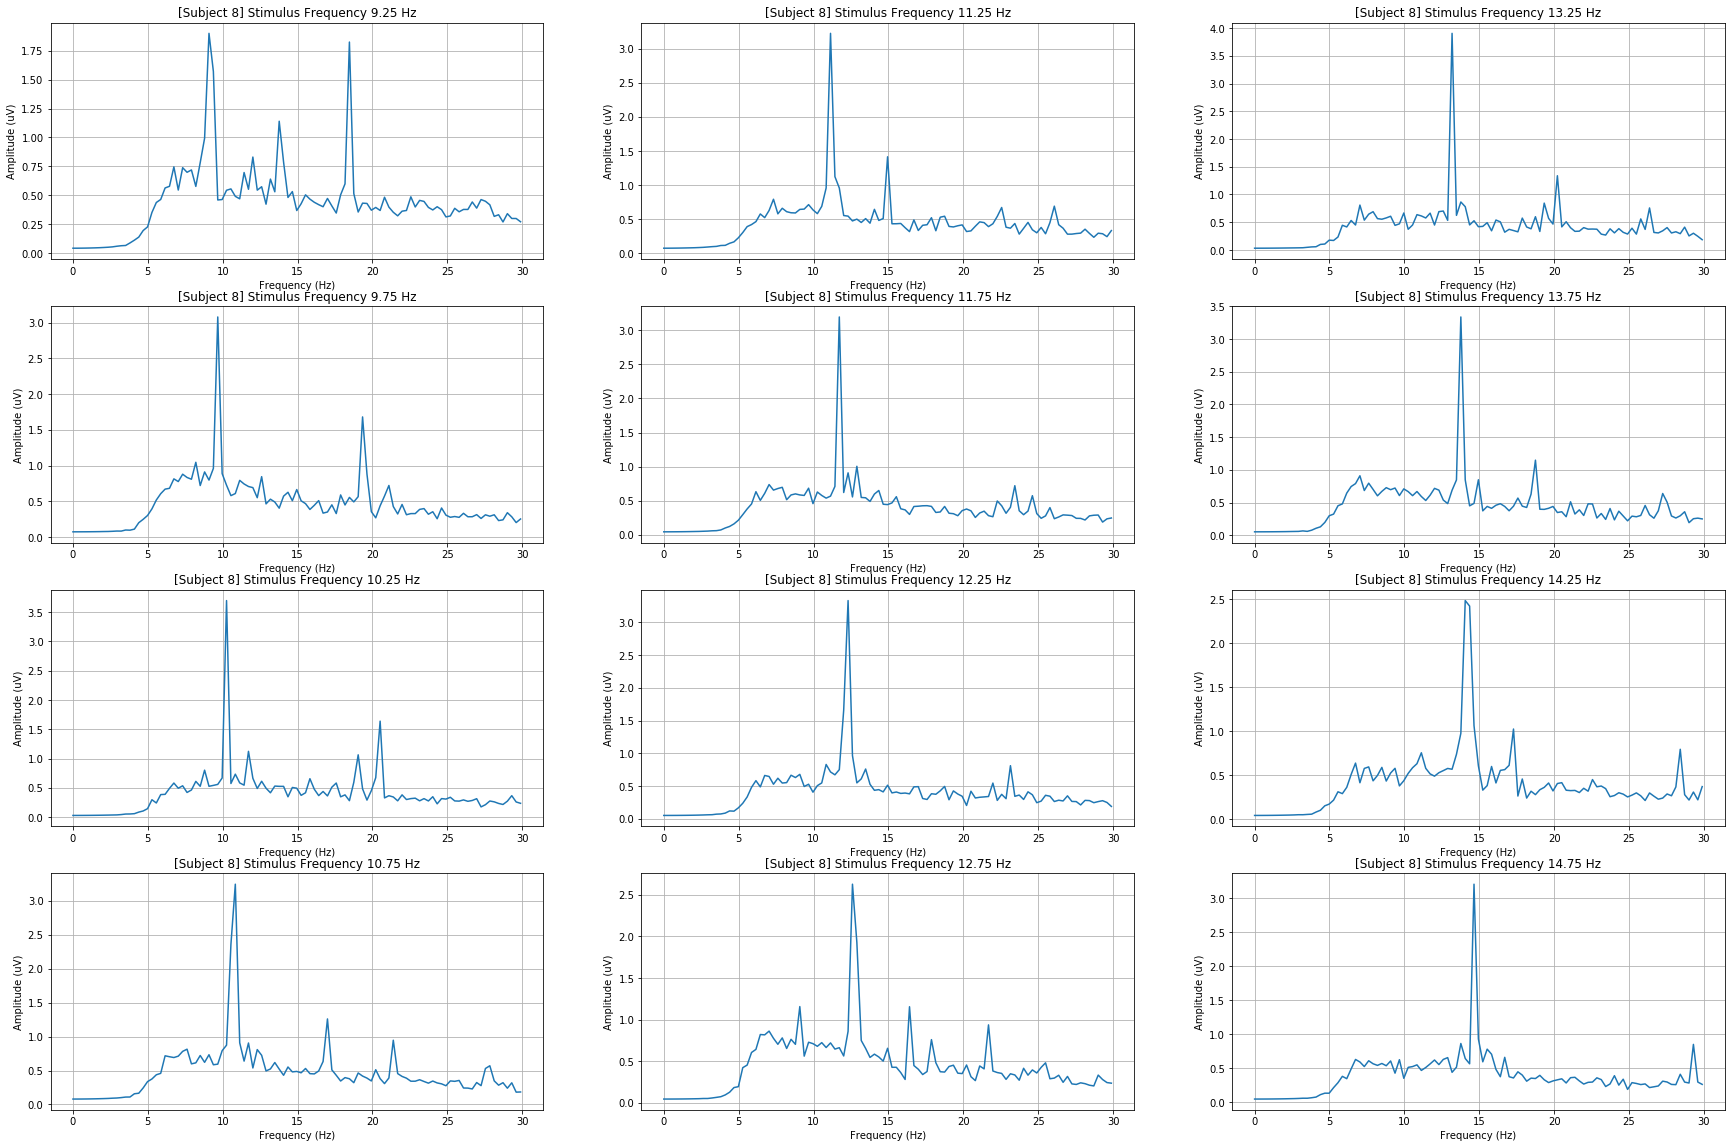

In [100]:
#Load subject 8 data with the FFT resolution of 0.2930 on channel Oz (7) between 0 Hz and 30 Hz
subject = 8
channel = 7
[fft_axis,features_data] = loadDataPlFft(subject,channel,0.2930,0,30)

### Subject 2 - Example dataset containing bad/noisy frequency response for each flicker frequency
In this case, the flicker frequencies are not easily distinguishable from one another based on the frequency response

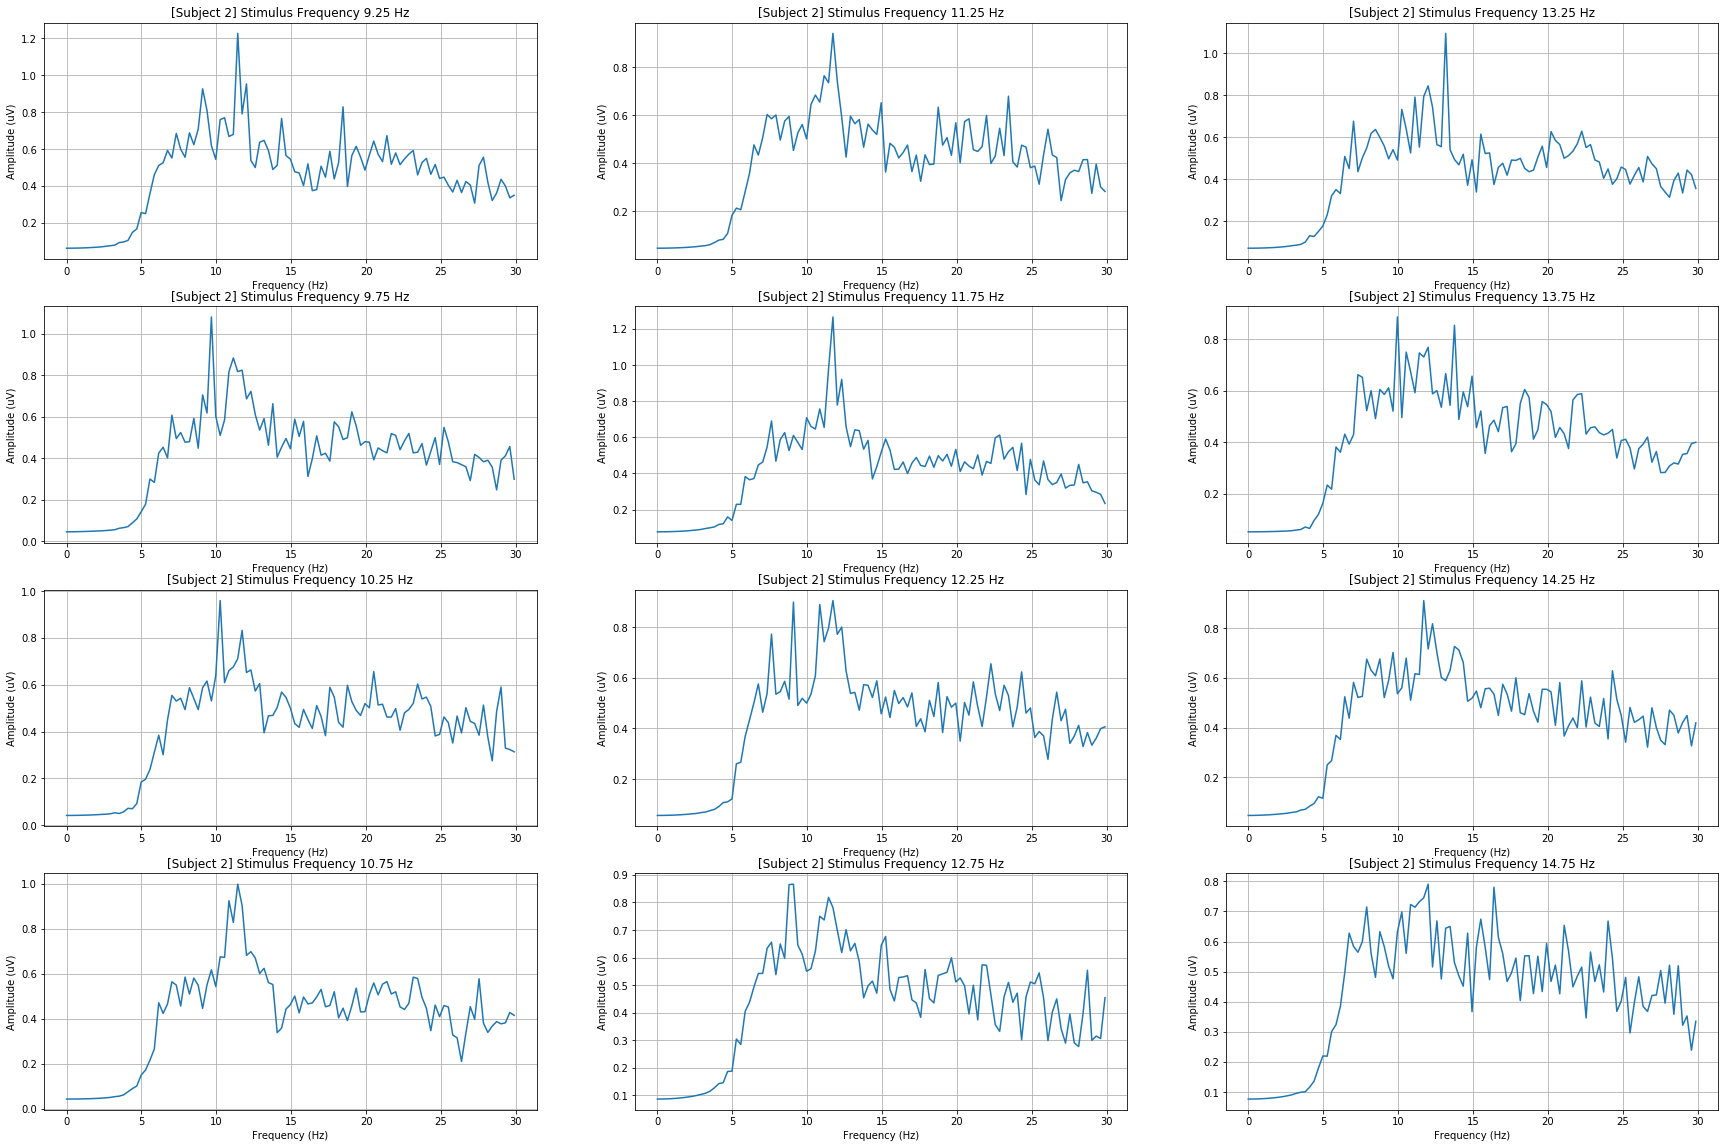

In [101]:
subject = 2
channel = 7
[fft_axis,features_data] = loadDataPlFft(subject,channel,0.2930,0,30)

#### Note: These responses are calculated for the signal duration of 4 s. The responses can vary if the signal duration was reduced.
#### This inter-subject variability can also be observed in the next section on Canonical Correlation Analysis (CCA) based classification of SSVEP responses.
Filename: notebook_12_class_cca.ipynb

